# Librairies

In [18]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Chargement de données

In [4]:
train_base_dir = '../Data/Data/train/'
clear_dir = os.path.join(train_base_dir, 'clear')
classes = ['clear', 'distorsion1', 'distorsion2', 'distorsion3','mvt1','mvt2','mvt3','gauss1','gauss2','gauss3','pixel1','pixel2','pixel3'] 

def verifier_et_lister_contenu(repertoire):
    if os.path.exists(repertoire):
        print(f"Le dossier '{repertoire}' contient les fichiers suivants :")
        for filename in os.listdir(repertoire):
            print(filename)
    else:
        print(f"Le dossier '{repertoire}' n'existe pas. Vérifiez le chemin.")

verifier_et_lister_contenu(clear_dir)


image_size = (224, 224)
batch_size = 64  


def charger_et_preparer_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)  
    img = tf.image.resize(img, image_size)  
    img = img / 255.0  
    return img


def charger_images_et_labels(repertoire, label):
    images_paths = [os.path.join(repertoire, filename) for filename in os.listdir(repertoire)]
    labels = [label] * len(images_paths)
    return images_paths, labels

clear_images, clear_labels = charger_images_et_labels(clear_dir, 0)

def create_tf_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda img_path, label: (charger_et_preparer_image(img_path), label), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


Le dossier '../Data/Data/train/clear' contient les fichiers suivants :
clear_1.jpg
clear_10.jpg
clear_100.jpg
clear_1000.jpg
clear_1001.jpg
clear_1002.jpg
clear_1003.jpg
clear_1004.jpg
clear_1005.jpg
clear_1006.jpg
clear_1007.jpg
clear_1008.jpg
clear_1009.jpg
clear_101.jpg
clear_1010.jpg
clear_1011.jpg
clear_1012.jpg
clear_1013.jpg
clear_1014.jpg
clear_1015.jpg
clear_1016.jpg
clear_1017.jpg
clear_1018.jpg
clear_1019.jpg
clear_102.jpg
clear_1020.jpg
clear_1021.jpg
clear_1022.jpg
clear_1023.jpg
clear_1024.jpg
clear_1025.jpg
clear_1026.jpg
clear_1027.jpg
clear_1028.jpg
clear_1029.jpg
clear_103.jpg
clear_1030.jpg
clear_1031.jpg
clear_1032.jpg
clear_1033.jpg
clear_1034.jpg
clear_1035.jpg
clear_1036.jpg
clear_1037.jpg
clear_1038.jpg
clear_1039.jpg
clear_104.jpg
clear_1040.jpg
clear_1041.jpg
clear_1042.jpg
clear_1043.jpg
clear_1044.jpg
clear_1045.jpg
clear_1046.jpg
clear_1047.jpg
clear_1048.jpg
clear_1049.jpg
clear_105.jpg
clear_1050.jpg
clear_1051.jpg
clear_1052.jpg
clear_1053.jpg
clear_1054

# Création du modèle

In [5]:


def create_model():
    model = keras.models.Sequential([
        keras.layers.Input((224, 224, 3)),
        keras.layers.Conv2D(32, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(2, activation='softmax')  # 2 classes
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [43]:
def process_model(model,obscur_dir) :

    obscur_images, obscur_labels = charger_images_et_labels(obscur_dir, 1)
    all_images = clear_images + obscur_images
    all_labels = clear_labels + obscur_labels
    X_train, X_val, y_train, y_val = train_test_split(all_images, all_labels, test_size=0.2, stratify=all_labels)



    train_dataset = create_tf_dataset(X_train, y_train)
    validation_dataset = create_tf_dataset(X_val, y_val)
    train_labels = np.concatenate([labels for _, labels in train_dataset], axis=0)
    val_labels = np.concatenate([labels for _, labels in validation_dataset], axis=0)
    print(f"Distribution des labels dans le jeu d'entraînement: {np.bincount(train_labels)}")
    print(f"Distribution des labels dans le jeu de validation: {np.bincount(val_labels)}")


    history = model.fit(
        train_dataset, 
        validation_data=validation_dataset,  
        epochs=5,   
        verbose=1    
    )

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title("Model accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    predictions = model.predict(validation_dataset)
    predictions = np.argmax(predictions, axis=1)
    true_labels = val_labels
    print(classification_report(true_labels, predictions))
    print(f"True labels: {true_labels[:10]}")
    print(f"Predictions: {predictions[:10]}")
    print(f"Shape of true_labels: {true_labels.shape}")
    print(f"Shape of predictions: {predictions.shape}")

    cm = confusion_matrix(true_labels, predictions, labels=[0, 1])
    class_names = [str(0),str(1)]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.savefig("matrice.png")
    plt.show()

    # Sauvegarde du modèle
    # model.save('my_model.keras') #modele lourd pour push sur git

# Distorsion

Distribution des labels dans le jeu d'entraînement: [1289 1291]
Distribution des labels dans le jeu de validation: [322 323]
Epoch 1/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 36s 855ms/step - accuracy: 0.5637 - loss: 3.3593 - val_accuracy: 0.7333 - val_loss: 0.4455
Epoch 2/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 35s 858ms/step - accuracy: 0.7789 - loss: 0.3707 - val_accuracy: 0.8124 - val_loss: 0.3295
Epoch 3/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 35s 840ms/step - accuracy: 0.8661 - loss: 0.2939 - val_accuracy: 0.8558 - val_loss: 0.2761
Epoch 4/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 826ms/step - accuracy: 0.8794 - loss: 0.2564 - val_accuracy: 0.8341 - val_loss: 0.3258
Epoch 5/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 36s 863ms/step - accuracy: 0.9526 - loss: 0.1661 - val_accuracy: 0.8760 - val_loss: 0.2522


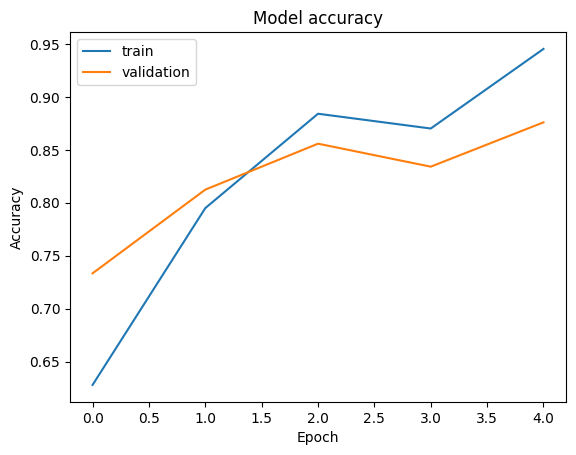

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step
              precision    recall  f1-score   support

           0       0.49      0.43      0.46       322
           1       0.49      0.55      0.52       323

    accuracy                           0.49       645
   macro avg       0.49      0.49      0.49       645
weighted avg       0.49      0.49      0.49       645

True labels: [1 1 1 1 0 1 1 1 0 1]
Predictions: [0 1 1 1 0 0 1 1 0 1]
Shape of true_labels: (645,)
Shape of predictions: (645,)


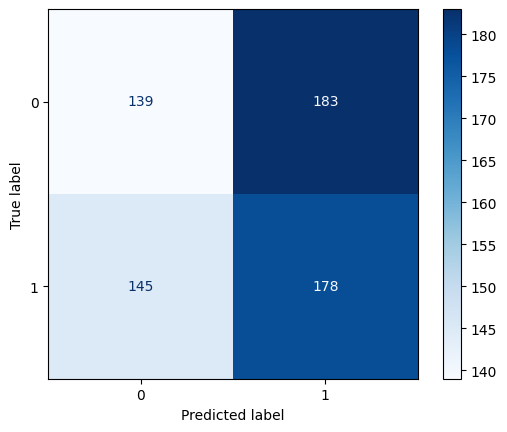

In [44]:
# DIstorsion1

model=create_model()
distorsion1_dir = os.path.join(train_base_dir, 'distorsion1')
process_model(model,distorsion1_dir)





In [ ]:
# DIstorsion2

model=create_model()
distorsion2_dir = os.path.join(train_base_dir, 'distorsion2')
process_model(model,distorsion2_dir)




Distribution des labels dans le jeu d'entraînement: [1289 1348]
Distribution des labels dans le jeu de validation: [322 338]
Epoch 1/3
42/42 ━━━━━━━━━━━━━━━━━━━━ 34s 768ms/step - accuracy: 0.5929 - loss: 3.0374 - val_accuracy: 0.9500 - val_loss: 0.1519
Epoch 2/3
42/42 ━━━━━━━━━━━━━━━━━━━━ 33s 778ms/step - accuracy: 0.9498 - loss: 0.1345 - val_accuracy: 0.9909 - val_loss: 0.0467
Epoch 3/3
42/42 ━━━━━━━━━━━━━━━━━━━━ 33s 768ms/step - accuracy: 0.9935 - loss: 0.0407 - val_accuracy: 0.9970 - val_loss: 0.0162


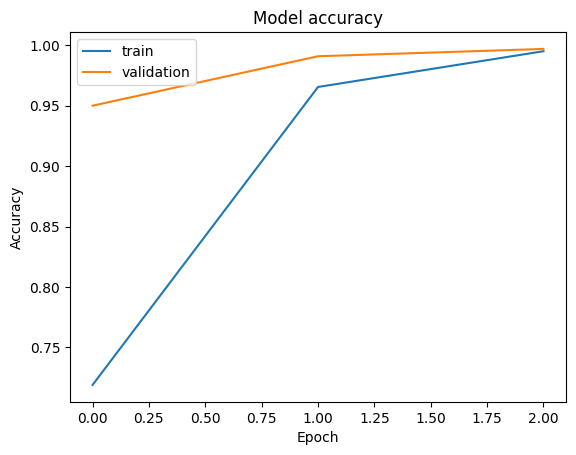

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step
              precision    recall  f1-score   support

           0       0.48      0.49      0.49       322
           1       0.51      0.51      0.51       338

    accuracy                           0.50       660
   macro avg       0.50      0.50      0.50       660
weighted avg       0.50      0.50      0.50       660

True labels: [0 1 0 0 0 0 1 0 0 0]
Predictions: [0 0 0 0 0 1 0 1 0 0]
Shape of true_labels: (660,)
Shape of predictions: (660,)


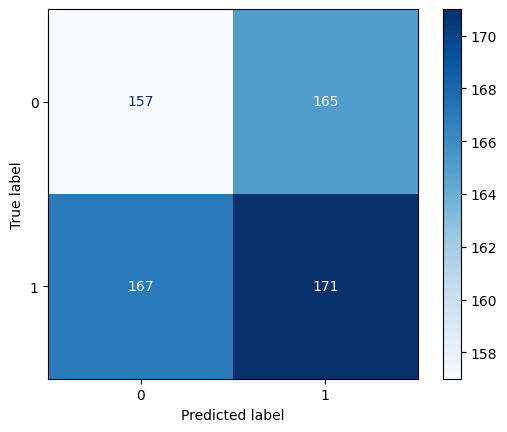

In [23]:
# DIstorsion3

model=create_model()
distorsion3_dir = os.path.join(train_base_dir, 'distorsion3')
process_model(model,distorsion3_dir)




# Flou Mouvement

In [ ]:
# Mvt1

model=create_model()
mvt1_dir = os.path.join(train_base_dir, 'mvt1')
process_model(model,mvt1_dir)



In [ ]:
# Mvt2

model=create_model()
mvt2_dir = os.path.join(train_base_dir, 'mvt2')
process_model(model,mvt2_dir)


In [ ]:
# Mvt3

model=create_model()
mvt3_dir = os.path.join(train_base_dir, 'mvt3')
process_model(model,mvt3_dir)



# Flou gaussien

In [ ]:
# Gauss1

model=create_model()
gauss1_dir = os.path.join(train_base_dir, 'gauss1')
process_model(model,gauss1_dir)



In [ ]:
# Gauss2

model=create_model()
gauss2_dir = os.path.join(train_base_dir, 'gauss2')
process_model(model,gauss2_dir)


In [ ]:
# Gauss3

model=create_model()
gauss3_dir = os.path.join(train_base_dir, 'gauss3')
process_model(model,gauss3_dir)


# Pixelisation

In [ ]:
# Pixel1

model=create_model()
pixel1_dir = os.path.join(train_base_dir, 'pixel1')
process_model(model,pixel1_dir)


In [ ]:
# Pixel2

model=create_model()
pixel2_dir = os.path.join(train_base_dir, 'pixel1')
process_model(model,pixel2_dir)

In [ ]:
# Pixel3

model=create_model()
pixel3_dir = os.path.join(train_base_dir, 'pixel3')
process_model(model,pixel3_dir)